In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
data = pd.read_csv('drive/My Drive/train.csv')

In [ ]:
data.head()
# Drop useless columns
drop_columns = ["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name", "Location of Institute", "Parental consent", "Place of birth"]
data_drop = data.drop(drop_columns,axis = 1)

data_drop = data_drop.dropna(subset = ['Disorder Subclass'], axis = 'rows').reset_index()

# Fill missing values in Genetic Disorder based on Disorder Subclass
for i in range(len(data_drop)):
    if data_drop.loc[i, "Disorder Subclass"] in ["Cystic fibrosis", "Hemochromatosis", "Tay-Sachs"]:
        data_drop.loc[i, "Genetic Disorder"] = "Single-gene inheritance diseases"
    elif data_drop.loc[i, "Disorder Subclass"] in ["Alzheimer's", "Cancer", "Diabetes"]:
        data_drop.loc[i, "Genetic Disorder"] = "Multifactorial genetic inheritance disorders"
    else:
        data_drop.loc[i, "Genetic Disorder"] = "Mitochondrial genetic inheritance disorders"
data_drop.drop('index', axis = 1, inplace = True)        

# Bin the continous variables to convert into ordinal categorical variables
pa_edges = np.histogram_bin_edges(data_drop['Patient Age'].dropna(), bins = 5)
data_drop['Patient Age'] = pd.cut(data_drop['Patient Age'], bins = pa_edges, labels = [x for x in range(len(pa_edges) - 1)])

ma_edges = np.histogram_bin_edges(data_drop['Mother\'s age'].dropna(), bins = 6)
data_drop['Mother\'s age'] = pd.cut(data_drop['Mother\'s age'], bins = ma_edges, labels = [x for x in range(len(ma_edges) - 1)])

fa_edges = np.histogram_bin_edges(data_drop['Father\'s age'].dropna(), bins = 6)
data_drop['Father\'s age'] = pd.cut(data_drop['Father\'s age'], bins = fa_edges, labels = [x for x in range(len(fa_edges) - 1)])

bcc_edges = np.histogram_bin_edges(data_drop['Blood cell count (mcL)'].dropna(), bins = 4)
data_drop['Blood cell count (mcL)'] = pd.cut(data_drop['Blood cell count (mcL)'], bins = bcc_edges, labels = [x for x in range(len(bcc_edges) - 1)])

wbcc_edges = np.histogram_bin_edges(data_drop['White Blood cell count (thousand per microliter)'].dropna(), bins = 4)
data_drop['White Blood cell count (thousand per microliter)'] = pd.cut(data_drop['White Blood cell count (thousand per microliter)'], bins = wbcc_edges, labels = [x for x in range(len(wbcc_edges) - 1)])

In [ ]:
# Import libraries
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Label encode all variables
encoder = defaultdict(LabelEncoder)
encoded_data = data_drop.apply(lambda series: pd.Series(encoder[series.name].fit_transform(series[series.notnull()]), index = series[series.notnull()].index))
encoded_data.head()

# Separate into predictors and response variables
X = encoded_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis = 1)
y = encoded_data[['Genetic Disorder', 'Disorder Subclass']]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass'])  # Train test split stratified by Disorder subclass

# use SimpleImputer to fill missing values with mode of each column
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)

X_train_imp = pd.DataFrame()
X_test_imp = pd.DataFrame()

X_train_imp[X_train.columns] = imputer.fit_transform(X_train)
X_test_imp[X_test.columns] = imputer.transform(X_test)

imputed_unenc_X_train = pd.DataFrame()
for x in X_train_imp:
  imputed_unenc_X_train[x] = list(encoder[x].inverse_transform(X_train_imp[x].apply(lambda y: int(y))))

imputed_unenc_X_test = pd.DataFrame()
for x in X_test_imp:
  imputed_unenc_X_test[x] = list(encoder[x].inverse_transform(X_test_imp[x].apply(lambda y: int(y))))

unenc_y_train = pd.DataFrame()
for x in y_train:
  unenc_y_train[x] = list(encoder[x].inverse_transform(y_train[x].apply(lambda y: int(y))))

unenc_y_test = pd.DataFrame()
for x in y_test:
  unenc_y_test[x] = list(encoder[x].inverse_transform(y_test[x].apply(lambda y: int(y))))

In [ ]:
### Supervised
## One-hot encoding

# Reform whole imputed dataset
data_drop_imputed = pd.concat([pd.concat([imputed_unenc_X_train, unenc_y_train],axis = 1),pd.concat([imputed_unenc_X_test, unenc_y_test],axis = 1)],axis =0)

ordinal_converter = {'Birth defects':['Singular','Multiple']}
for k, v in ordinal_converter.items():
  data_drop_imputed[k] = [v.index(x) for x in data_drop_imputed[k]]

# Classify nominal and ordinal data
ordinal = []
nominal = []
for i in data_drop_imputed:
  if isinstance(list(data_drop_imputed[i].unique())[0], np.int64) or isinstance(list(data_drop_imputed[i].unique())[0], np.float64):
    ordinal.append(i)
  else:
    nominal.append(i)

# One Hot encoding to all to account for nominal data
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
encoder = defaultdict(OneHotEncoder)
data_drop_encoded = data_drop_imputed.copy()
nominal.remove('Disorder Subclass')
nominal.remove('Genetic Disorder')
data_drop_encoded.drop(labels = nominal, axis = 1, inplace = True)
for i in nominal:
  data_drop_encoded = pd.concat([data_drop_encoded, pd.DataFrame(encoder[i].fit_transform(data_drop_imputed[[i]]).toarray(), index = data_drop_imputed[[i]].index, columns = encoder[i].get_feature_names_out ())], axis = 1)

X = data_drop_encoded.drop(['Disorder Subclass', 'Genetic Disorder'], axis = 1)
y = data_drop_encoded[['Disorder Subclass', 'Genetic Disorder']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass'])  # Train test split stratified by Disorder subclass

y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

In [ ]:
# Naive Bayes Genetic Disorder

# Import libraries
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import CategoricalNB
# Iterate the model for 30 times to get average performance
all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}

for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract out Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_nb = CategoricalNB() # Instantiate model
    main_class_nb.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_nb.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_nb.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(main_class_nb, pd.DataFrame(X_train), y_train_main, cv = 5).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(main_class_nb, X_test, y_test_main, cv = 5).mean())  # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,30.000000,30.000000,30.000000,30.000000
mean,0.537060,0.526806,0.525136,0.494686
std,0.002180,0.003712,0.002598,0.006504
min,0.532074,0.517700,0.518328,0.481299
25%,0.535353,0.524730,0.523444,0.489768
50%,0.537032,0.526488,0.525233,0.495230
75%,0.538602,0.528433,0.526974,0.499503
max,0.541865,0.533517,0.529249,0.507418


In [ ]:
# Support Vector Machine
from sklearn import svm

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[]}
# Iterate the model for 30 times to get average performance
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    main_class_svm = svm.SVC(decision_function_shape='ovo') # Instantiate model
    main_class_svm.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(main_class_svm.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(main_class_svm.score(X_test, y_test_main)) # Test set accuracy

display(pd.DataFrame(all_scores).describe())

,Accuracy(Train),Accuracy(Test)
count,30.000000,30.000000
mean,0.535099,0.523031
std,0.002462,0.002063
min,0.529877,0.519458
25%,0.533470,0.521278
50%,0.535463,0.522722
75%,0.537017,0.524165
max,0.539731,0.526990


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

all_scores = {'Accuracy(Train)':[],
              'Accuracy(Test)':[],
              '5-Fold-CV(Train)':[],
              '5-Fold-CV(Test)':[]}
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y['Disorder Subclass']) # Train test split stratified by Disorder subclass
    y_train_main = y_train['Genetic Disorder'] # Extract Train Genetic Disorder 
    y_test_main = y_test['Genetic Disorder'] # Extract Test Genetic Disorder

    randfor = RandomForestClassifier(n_estimators = 100, max_depth = 3, n_jobs = -1) # Instantiate model
    randfor.fit(X_train, y_train_main) # Fit model
    all_scores['Accuracy(Train)'].append(randfor.score(X_train, y_train_main)) # Train set accuracy
    all_scores['Accuracy(Test)'].append(randfor.score(X_test, y_test_main)) # Test set accuracy
    all_scores['5-Fold-CV(Train)'].append(cross_val_score(randfor, pd.DataFrame(X_train), y_train_main, cv = 5, n_jobs = -1).mean()) # Train set 5-fold cross-validation
    all_scores['5-Fold-CV(Test)'].append(cross_val_score(randfor, X_test, y_test_main, cv = 5, n_jobs = -1).mean())   # Test set 5-fold cross-validation

display(pd.DataFrame(all_scores).describe())

,Accuracy(Train),Accuracy(Test),5-Fold-CV(Train),5-Fold-CV(Test)
count,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01
mean,5.128044e-01,5.129300e-01,5.128044e-01,5.129300e-01
std,2.258405e-16,2.258405e-16,2.258405e-16,3.177789e-07
min,5.128044e-01,5.129300e-01,5.128044e-01,5.129298e-01
25%,5.128044e-01,5.129300e-01,5.128044e-01,5.129298e-01
50%,5.128044e-01,5.129300e-01,5.128044e-01,5.129298e-01
75%,5.128044e-01,5.129300e-01,5.128044e-01,5.129304e-01
max,5.128044e-01,5.129300e-01,5.128044e-01,5.129304e-01


<BarContainer object of 2 artists>

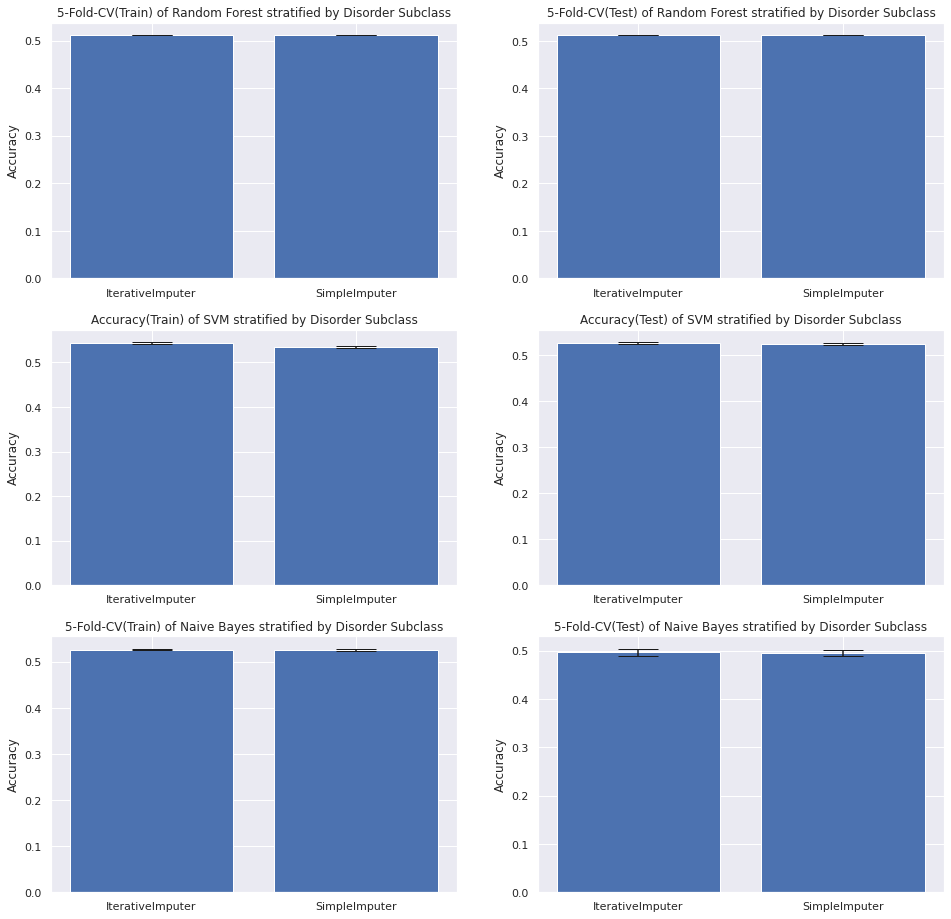

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(16,16))

axs[0, 0].set(title='5-Fold-CV(Train) of Random Forest stratified by Disorder Subclass', ylabel='Accuracy')
axs[0, 0].bar(['IterativeImputer', 'SimpleImputer'], [5.128044e-01,5.128044e-01], yerr=[2.258405e-16,2.258405e-16], capsize=20)

axs[0, 1].set(title='5-Fold-CV(Test) of Random Forest stratified by Disorder Subclass', ylabel='Accuracy')
axs[0, 1].bar(['IterativeImputer', 'SimpleImputer'], [0.512947,5.129300e-01], yerr=[0.000064,3.177789e-07], capsize=20)

axs[1, 0].set(title='Accuracy(Train) of SVM stratified by Disorder Subclass', ylabel='Accuracy')
axs[1, 0].bar(['IterativeImputer', 'SimpleImputer'], [0.543631,0.535099], yerr=[0.003017,0.002462], capsize=20)

axs[1, 1].set(title='Accuracy(Test) of SVM stratified by Disorder Subclass', ylabel='Accuracy')
axs[1, 1].bar(['IterativeImputer', 'SimpleImputer'], [0.526755,0.523031], yerr=[0.002092,0.002063],capsize=20)

axs[2, 0].set(title='5-Fold-CV(Train) of Naive Bayes stratified by Disorder Subclass', ylabel='Accuracy')
axs[2, 0].bar(['IterativeImputer', 'SimpleImputer'], [0.526488,0.525136], yerr=[0.001840,0.002598],capsize=20)

axs[2, 1].set(title='5-Fold-CV(Test) of Naive Bayes stratified by Disorder Subclass', ylabel='Accuracy')
axs[2, 1].bar(['IterativeImputer', 'SimpleImputer'], [0.496745,0.494686], yerr=[0.007286,0.006504],capsize=20)